In [1]:
import tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_absolute_percentage_error
from sklearn.linear_model import LogisticRegression, Lasso
#from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA, NMF
from sklearn import preprocessing as p

pd.set_option('display.max_columns', None)

2023-04-13 15:59:40.261306: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 15:59:40.320021: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 15:59:40.320831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 15:59:41.276146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Descriere Task**

De construit un model care sa identifice "clientii buni" si "clientii riscanti" pentru
credite in rate (Pinguin, Crab) sau linii de disponibil (Defin)

**Columns INFO**

○ Data start si Data inchidere.

○ CreditLimit acordat

○ Stare curenta credit la momentul listei

○ Scor: maxim posibil e 850. De pe la 650 esti "bancabil". De pe la 450 s-au dat

aceste credite. Scorul vine de la Biroul de Credite

○ Probabilitatea de plata, pe modelul actual. Maxim e 1. Sub 0.5 in teorie ar 
trebui sa nu se dea credite, dar s-au dat.

○ Venit declarat + venit confirmat de la ANAF

○ TotalLoanPayments : cit are de plata lunar la alte credite. Asta se scade din
40% * ANAFIncome, => BNR40Availability ramasa pentru noi. BNR permite sa
platesti pentru credite maxim 40% din venitul tau pe luna.

○ Credite deja inchise la noi inainte de acesta.

○ Crab, Penguin, DolphinOffer respectand limita BNR40

○ Crab, Penguin, DolphinIgnoringBNR , daca oamenii vin cu o motivare legala
(studii, sanatate, decese)

○ Categorie client, rezultand din [scor, varsta, venit confirmat]. 1 e bine, 2 mediu,
3 e slab.

○ Withdrawn (cit s-a retras din CreditAmount. Pe Delfin, fiind linie de credit, daca
pui banii inapoi poti sa retragi iar, deci poti retrage mult mai mult in total.

○ DpdDiffDaysMax : numarul de zile maxim cu care a fost in depasire de data
factura, pe parcursul creditului. Daca a platit in avans, e negativ. Daca e peste
90, e bun de dat in executare.

○ DPDtotal: daca creditul nu e inchis si omul e peste data factura, cu cit e dator
in total. azi. Poate fi 0 daca nu e peste data factura.

○ PaidTotal: ce a platit omul deja inapoi catre noi.

○ FutureTotal: daca creditul nu e inchis, suma de platit pentru care inca nu s-a
emis factura. De exemplu daca pe Pinguin a trecut doar rata 1, astea sunt
sumele din rata 2 si 3.

○ IsDerrogationBNR: s-a acordat derogare pe o motivare legala.

In [2]:
os.listdir()

['Test_sarcina.ipynb',
 '.ipynb_checkpoints',
 'requirements.txt',
 'Copy of OC-CreditsHistory-WithOffer-MarginOrProvision.xlsx',
 'Sarcina test - data scientist.pdf']

In [3]:
dataset = pd.read_excel('Copy of OC-CreditsHistory-WithOffer-MarginOrProvision.xlsx', header=2)

In [4]:
dataset.head()

,CNP,Gender,Age,DataSemnarii,DataInchis,Number,Produs,CreditLimit,State,scoringdate,score,ProbabilityOfModel,DeclIncome,ANAFIncome,TotalLoanPayments,BNR40Available,CreditsBefore,OfferCrab,OfferPenguin,OfferDolphin,CrabIgnoringBNR,PenguinIgnoringBNR,DolphinIgnoringBNR,ClientCategory,Comission,Withdrawed,DpdDiffDaysMax,DpdTotal,PaidTotal,FutureTotal,IsDerrogationBNR
0,1900226063350,M,32,2021-10-15 18:37:54,2021-10-16 18:11:03,DK53851057,Penguin,1900,Inchis,2021-10-15 00:31:13,589,1.0000,5500,4980,1283,709,6,600,1900,3000,0,0,0,0,0,-1900.0,-27,0.0,1907.56,0.0,NaN
1,1900226063350,M,32,2021-11-06 03:38:12,2021-12-10 12:29:02,TC42768422,Penguin,700,Inchis,2021-10-15 00:31:13,589,1.0000,5500,4980,1283,709,7,600,1900,3000,0,0,0,0,0,-700.0,-22,0.0,783.58,0.0,NaN
2,1811228048420,M,41,2021-10-15 10:43:41,2022-01-14 16:20:02,HP51173676,Penguin,2000,Inchis,2021-10-15 07:34:50,608,0.9994,4500,4868,2847,-2847,7,700,2000,3000,0,0,0,0,0,-2000.0,3,0.0,2239.08,0.0,NaN
3,2821224845270,F,40,2021-10-17 10:21:42,2021-12-08 11:55:03,CL14119436,Penguin,700,Inchis,2021-10-15 08:26:57,581,0.9935,3900,4888,3360,-1404,2,200,700,0,0,0,0,0,0,-700.0,-5,0.0,783.58,0.0,NaN
4,1890122104070,M,33,2021-10-15 08:49:02,2021-12-04 10:04:03,XJ11096426,Crab,900,Inchis,2021-10-15 08:43:58,590,0.9998,6000,7784,1031,2082,3,1000,4500,6000,0,0,0,0,0,-900.0,-8,0.0,1185.00,0.0,NaN


In [5]:
dataset.columns = dataset.columns.str.lower()

In [6]:
dataset.describe()

,cnp,age,datasemnarii,datainchis,creditlimit,scoringdate,score,probabilityofmodel,declincome,anafincome,totalloanpayments,bnr40available,creditsbefore,offercrab,offerpenguin,offerdolphin,crabignoringbnr,penguinignoringbnr,dolphinignoringbnr,clientcategory,comission,withdrawed,dpddiffdaysmax,dpdtotal,paidtotal,futuretotal,isderrogationbnr
count,1.251600e+04,12516.000000,12516,6827,12516.000000,12516,12516.000000,12516.000000,1.251600e+04,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000,1111.0
mean,2.420533e+12,33.617370,2022-03-29 05:29:24.606903296,2022-04-18 22:14:31.368536832,2644.343241,2022-03-24 09:41:36.967241984,547.054890,0.757050,5.513298e+03,4555.810562,1227.006711,314.544663,3.664589,596.124880,1907.853867,3088.630553,597.674976,2185.754235,2904.274529,1.803132,6.121445,-3878.460329,12.434004,-530.649826,2954.626649,1043.417658,1.0
min,1.481020e+12,18.000000,2021-10-15 08:49:02,2021-10-16 14:25:04,500.000000,2021-10-15 00:31:13,-1.000000,0.000000,0.000000e+00,0.000000,0.000000,-101462.000000,0.000000,-1000.000000,-100.000000,0.000000,-1000.000000,-3000.000000,0.000000,0.000000,0.000000,-97059.820000,-50.000000,-15441.280000,0.000000,0.000000,1.0
25%,1.880626e+12,27.000000,2022-01-13 16:54:54.500000,2022-02-14 12:53:07.500000,1000.000000,2022-01-11 18:36:23,521.000000,0.625000,2.718750e+03,2842.000000,278.750000,-117.000000,0.000000,300.000000,800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,-4520.330000,-1.000000,0.000000,621.535000,0.000000,1.0
50%,1.960510e+12,32.000000,2022-03-29 18:14:59,2022-04-19 11:55:03,2400.000000,2022-03-22 18:00:10,557.000000,0.975900,3.700000e+03,3852.000000,859.000000,399.000000,1.000000,600.000000,1700.000000,3100.000000,800.000000,2400.000000,3200.000000,2.000000,7.000000,-2400.000000,0.000000,0.000000,1345.795000,0.000000,1.0
75%,2.861022e+12,39.000000,2022-06-09 20:34:30.750000128,2022-06-23 15:07:33,4000.000000,2022-06-03 18:51:47.500000,601.000000,0.998400,5.000000e+03,5261.000000,1674.000000,941.000000,5.000000,1000.000000,2900.000000,4000.000000,1000.000000,4100.000000,4000.000000,3.000000,9.000000,-1000.000000,1.000000,0.000000,3555.007500,1555.927500,1.0
max,7.620119e+12,74.000000,2022-09-02 16:40:21,2022-09-02 16:20:06,9000.000000,2022-09-02 16:12:04,798.000000,1.000000,1.390789e+07,122794.000000,103920.000000,35720.000000,59.000000,1500.000000,4500.000000,9000.000000,1500.000000,4500.000000,9000.000000,3.000000,9.000000,0.000000,303.000000,0.000000,93512.820000,9279.000000,1.0
std,8.851153e+11,8.924886,NaN,NaN,1907.315636,NaN,121.210187,0.363006,1.243703e+05,3433.366562,1740.284085,1705.722358,5.606157,363.329397,1353.698173,2505.953154,455.000392,1822.689815,2651.977775,1.273565,3.487703,5330.545463,47.625551,1651.693084,4913.331501,1862.397736,0.0


In [7]:
# ideas:
# filter by closed clients - not relevant
# create new feature credit period in days
# pay attention on those with probability and how they finally closed the credit
# let's ignore lineignoringbnr to consider the worst scenario

In [8]:
dataset_cleaned = dataset[['gender', 'age', 'datasemnarii',
                         'datainchis', 'creditlimit', 'state', 'score',
                         'probabilityofmodel', 'declincome', 'bnr40available', 
                         'creditsbefore', 'offercrab', 'offerpenguin', 'offerdolphin', 
                         'clientcategory', 'withdrawed', 'dpddiffdaysmax',
                         'paidtotal'
                        ]]
dataset_cleaned.head()

,gender,age,datasemnarii,datainchis,creditlimit,state,score,probabilityofmodel,declincome,bnr40available,creditsbefore,offercrab,offerpenguin,offerdolphin,clientcategory,withdrawed,dpddiffdaysmax,paidtotal
0,M,32,2021-10-15 18:37:54,2021-10-16 18:11:03,1900,Inchis,589,1.0000,5500,709,6,600,1900,3000,0,-1900.0,-27,1907.56
1,M,32,2021-11-06 03:38:12,2021-12-10 12:29:02,700,Inchis,589,1.0000,5500,709,7,600,1900,3000,0,-700.0,-22,783.58
2,M,41,2021-10-15 10:43:41,2022-01-14 16:20:02,2000,Inchis,608,0.9994,4500,-2847,7,700,2000,3000,0,-2000.0,3,2239.08
3,F,40,2021-10-17 10:21:42,2021-12-08 11:55:03,700,Inchis,581,0.9935,3900,-1404,2,200,700,0,0,-700.0,-5,783.58
4,M,33,2021-10-15 08:49:02,2021-12-04 10:04:03,900,Inchis,590,0.9998,6000,2082,3,1000,4500,6000,0,-900.0,-8,1185.00


In [9]:
closed_cases = dataset_cleaned.query("state == 'Inchis'").reset_index(drop=True)
#active_cases = dataset_cleaned.query("state == 'Activ'").reset_index(drop=True)

In [10]:
closed_cases.clientcategory.unique()

array([0, 3, 2, 1])

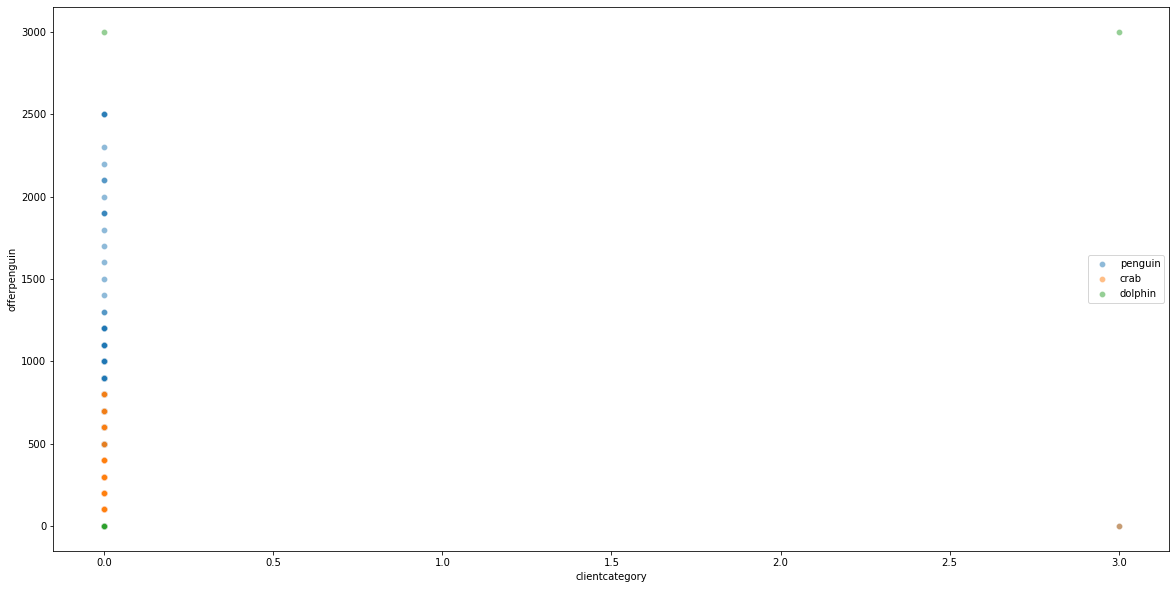

In [11]:
plt.figure(figsize=(20,10))
certain_score = closed_cases.query("score == -1")
sns.scatterplot(certain_score, x='clientcategory', y='offerpenguin', alpha=0.5, label='penguin')

sns.scatterplot(certain_score, x='clientcategory', y='offercrab', alpha=0.5, label='crab')

sns.scatterplot(certain_score, x='clientcategory', y='offerdolphin', alpha=0.5, label='dolphin')
plt.show()

Here's the obvious correlation between uncertain category and and negative score. This means that those with score = -1 would not fit

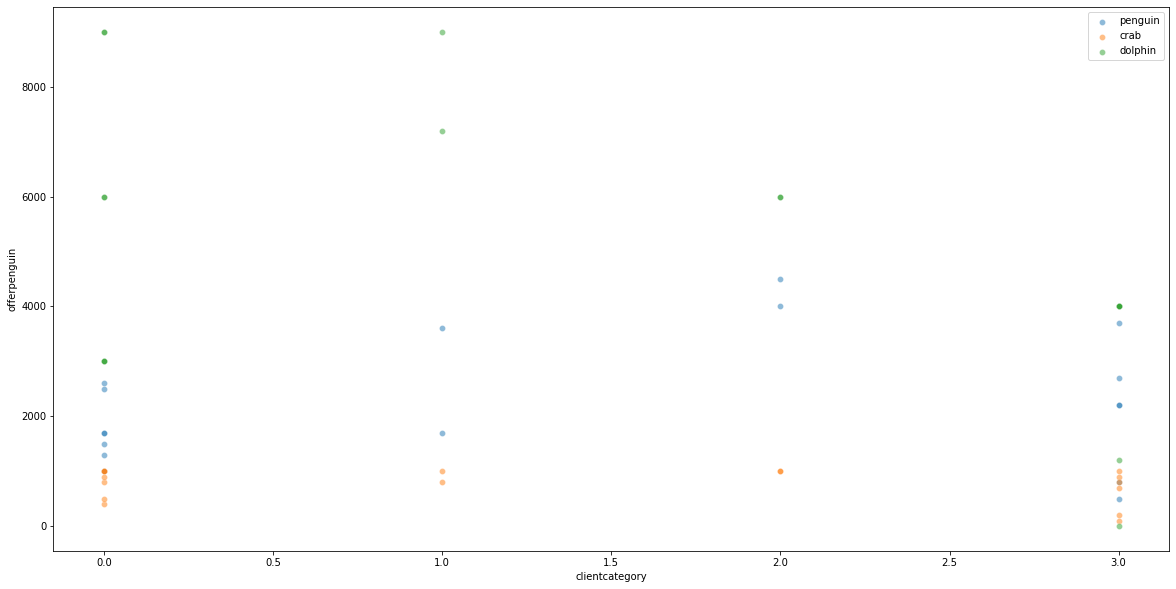

In [12]:
plt.figure(figsize=(20,10))
certain_score = closed_cases.query("score == 0")
sns.scatterplot(certain_score, x='clientcategory', y='offerpenguin', alpha=0.5, label='penguin')

sns.scatterplot(certain_score, x='clientcategory', y='offercrab', alpha=0.5, label='crab')

sns.scatterplot(certain_score, x='clientcategory', y='offerdolphin', alpha=0.5, label='dolphin')
plt.show()

The situation with score = 0 becomes unclear, so here other features should be taken into account 

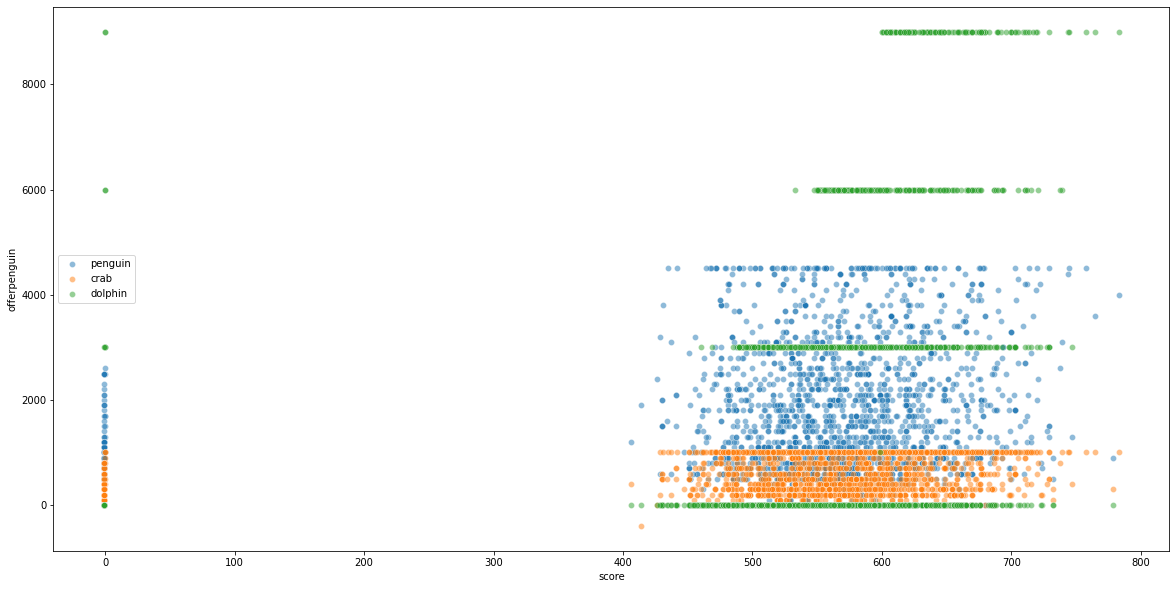

In [13]:
plt.figure(figsize=(20,10))
certain_clients = closed_cases.query("clientcategory == 0")

sns.scatterplot(certain_clients, x='score', y='offerpenguin', alpha=0.5, label='penguin')

sns.scatterplot(certain_clients, x='score', y='offercrab', alpha=0.5, label='crab')

sns.scatterplot(certain_clients, x='score', y='offerdolphin', alpha=0.5, label='dolphin')
plt.show()

It's hard to say which option and score goes with uncertain clients. Let's look at the others

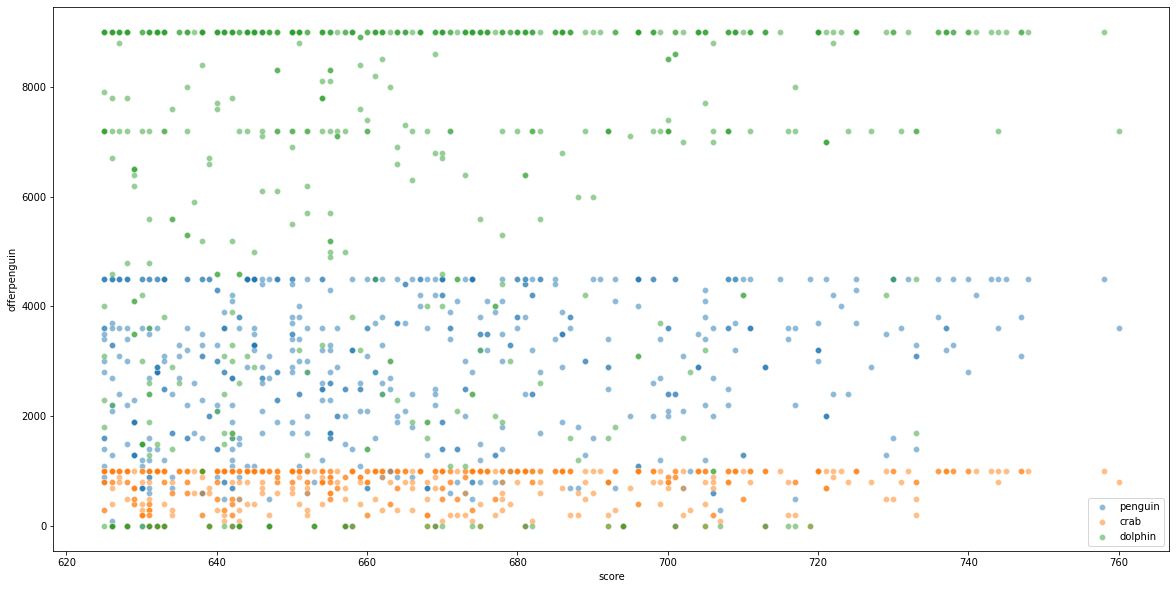

In [14]:
plt.figure(figsize=(20,10))
certain_client = closed_cases.query("clientcategory == 1 and score != 0")

sns.scatterplot(certain_client, x='score', y='offerpenguin', alpha=0.5, label='penguin')

sns.scatterplot(certain_client, x='score', y='offercrab', alpha=0.5, label='crab')

sns.scatterplot(certain_client, x='score', y='offerdolphin', alpha=0.5, label='dolphin')
plt.show()

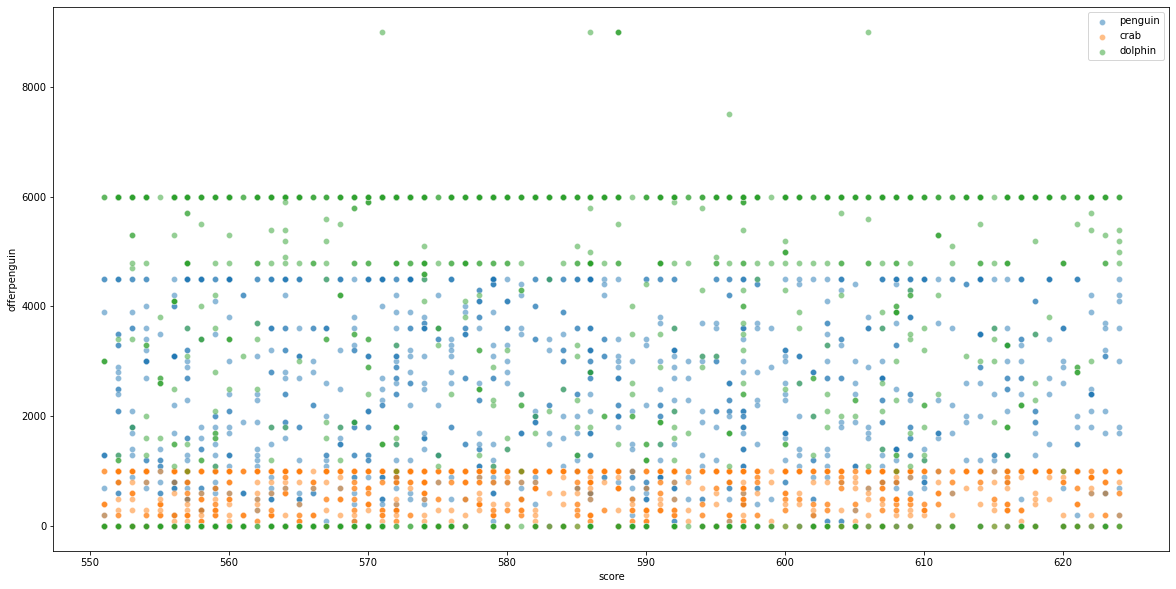

In [15]:
plt.figure(figsize=(20,10))
certain_client = closed_cases.query("clientcategory == 2 and score != 0")

sns.scatterplot(certain_client, x='score', y='offerpenguin', alpha=0.5, label='penguin')

sns.scatterplot(certain_client, x='score', y='offercrab', alpha=0.5, label='crab')

sns.scatterplot(certain_client, x='score', y='offerdolphin', alpha=0.5, label='dolphin')
plt.show()

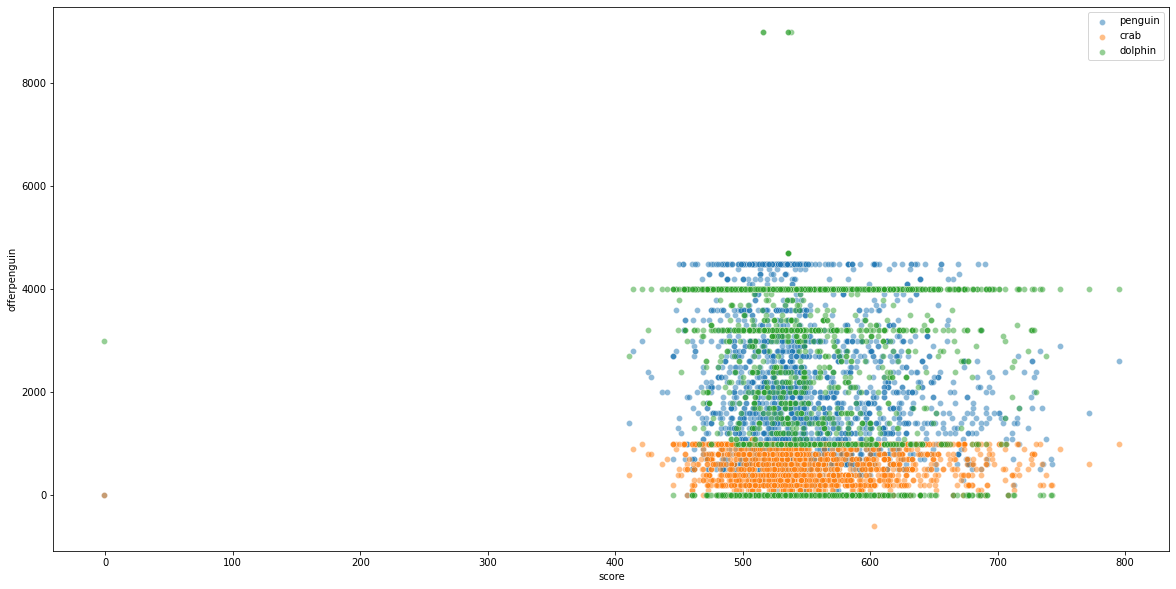

In [16]:
plt.figure(figsize=(20,10))
certain_client = closed_cases.query("clientcategory == 3 and score != 0")

sns.scatterplot(certain_client, x='score', y='offerpenguin', alpha=0.5, label='penguin')

sns.scatterplot(certain_client, x='score', y='offercrab', alpha=0.5, label='crab')

sns.scatterplot(certain_client, x='score', y='offerdolphin', alpha=0.5, label='dolphin')
plt.show()

The better clientcategory the bigger amount is provided per each category

In [17]:
closed_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6827 entries, 0 to 6826
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   gender              6827 non-null   object        
 1   age                 6827 non-null   int64         
 2   datasemnarii        6827 non-null   datetime64[ns]
 3   datainchis          6827 non-null   datetime64[ns]
 4   creditlimit         6827 non-null   int64         
 5   state               6827 non-null   object        
 6   score               6827 non-null   int64         
 7   probabilityofmodel  6827 non-null   float64       
 8   declincome          6827 non-null   int64         
 9   bnr40available      6827 non-null   int64         
 10  creditsbefore       6827 non-null   int64         
 11  offercrab           6827 non-null   int64         
 12  offerpenguin        6827 non-null   int64         
 13  offerdolphin        6827 non-null   int64       

In [18]:
timedelta = closed_cases.datainchis - closed_cases.datasemnarii 

In [19]:
closed_cases['openedhours'] = timedelta.dt.total_seconds()/3600

<AxesSubplot:>

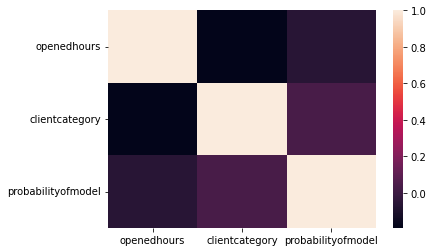

In [20]:
sns.heatmap(closed_cases[['openedhours', 'clientcategory', 'probabilityofmodel']].corr())

Seems like openedhours columns doesn't have anything with client's risk rate.

Let's take a closer look to the amount offered by different lines

In [21]:
dataset_cleaned[['offercrab', 'offerpenguin', 'offerdolphin']].quantile(np.linspace(0, 1, 11))

,offercrab,offerpenguin,offerdolphin
0.0,-1000.0,-100.0,0.0
0.1,0.0,0.0,0.0
0.2,200.0,700.0,0.0
0.3,300.0,1000.0,1300.0
0.4,500.0,1300.0,3000.0
0.5,600.0,1700.0,3100.0
0.6,800.0,2100.0,4000.0
0.7,1000.0,2600.0,4000.0
0.8,1000.0,3200.0,4800.0
0.9,1000.0,4100.0,6000.0


Let's divide those amount into groups to assign sort of rate per each category, where 1 is the smallest amount/decline and 4 is the best offer

In [22]:
bins_crab = [-1000, 250, 600, 1000, 1500]
bins_penguin = [-100, 850, 1700, 2900, 4500]
bins_dolphin = [0, 1000, 3100, 4400, 9000]

labels = [1, 2, 3, 4]

In [23]:
dataset_cleaned['offercr_b'] = pd.cut(x=dataset_cleaned['offercrab'], 
                                   bins=bins_crab, 
                                   include_lowest=True,
                                   labels=labels)

dataset_cleaned['offerdo_b'] = pd.cut(x=dataset_cleaned['offerdolphin'], 
                                   bins=bins_dolphin, 
                                   include_lowest=True,
                                   labels=labels)

dataset_cleaned['offerpe_b'] = pd.cut(x=dataset_cleaned['offerpenguin'], 
                                   bins=bins_penguin, 
                                   include_lowest=True,
                                   labels=labels)

/tmp/ipykernel_124806/2898613893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned['offercr_b'] = pd.cut(x=dataset_cleaned['offercrab'],
/tmp/ipykernel_124806/2898613893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_cleaned['offerdo_b'] = pd.cut(x=dataset_cleaned['offerdolphin'],
/tmp/ipykernel_124806/2898613893.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [24]:
dataset_cleaned = dataset_cleaned.drop(
    ['datasemnarii', 'datainchis', 'gender', 'age', 'declincome', 'state'], axis=1
) #drop dupes/extras

dataset_cleaned

,creditlimit,score,probabilityofmodel,bnr40available,creditsbefore,offercrab,offerpenguin,offerdolphin,clientcategory,withdrawed,dpddiffdaysmax,paidtotal,offercr_b,offerdo_b,offerpe_b
0,1900,589,1.0000,709,6,600,1900,3000,0,-1900.0,-27,1907.56,2,2,3
1,700,589,1.0000,709,7,600,1900,3000,0,-700.0,-22,783.58,2,2,3
2,2000,608,0.9994,-2847,7,700,2000,3000,0,-2000.0,3,2239.08,3,2,3
3,700,581,0.9935,-1404,2,200,700,0,0,-700.0,-5,783.58,1,1,1
4,900,590,0.9998,2082,3,1000,4500,6000,0,-900.0,-8,1185.00,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12511,2400,520,0.9544,-2271,22,0,0,0,3,-2400.0,0,0.00,1,1,1
12512,2400,539,0.9960,1431,2,800,2700,3200,3,-2400.0,0,0.00,3,3,3
12513,2500,481,0.9891,190,8,800,2500,3200,3,-2500.0,-28,2509.98,3,3,3
12514,3200,481,0.9713,190,9,800,2500,3200,3,-3200.0,0,0.00,3,3,3


In [25]:
X = dataset_cleaned.drop(
    ["offercrab", "offerpenguin", "offerdolphin"],
    axis=1
).iloc[:, :-3]
X

,creditlimit,score,probabilityofmodel,bnr40available,creditsbefore,clientcategory,withdrawed,dpddiffdaysmax,paidtotal
0,1900,589,1.0000,709,6,0,-1900.0,-27,1907.56
1,700,589,1.0000,709,7,0,-700.0,-22,783.58
2,2000,608,0.9994,-2847,7,0,-2000.0,3,2239.08
3,700,581,0.9935,-1404,2,0,-700.0,-5,783.58
4,900,590,0.9998,2082,3,0,-900.0,-8,1185.00
...,...,...,...,...,...,...,...,...,...
12511,2400,520,0.9544,-2271,22,3,-2400.0,0,0.00
12512,2400,539,0.9960,1431,2,3,-2400.0,0,0.00
12513,2500,481,0.9891,190,8,3,-2500.0,-28,2509.98
12514,3200,481,0.9713,190,9,3,-3200.0,0,0.00


<AxesSubplot:>

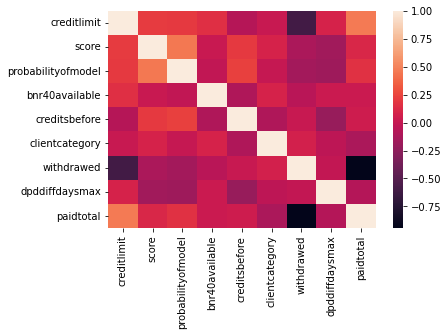

In [26]:
correlation = X.corr()
correlation[correlation < 0.4] = 0
sns.heatmap(X.corr())

Let's rely on score and probability as navigators  

<AxesSubplot:>

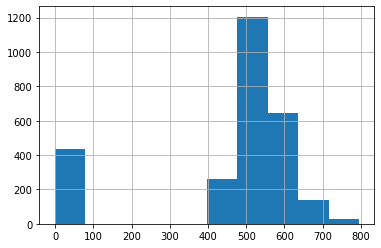

In [27]:
X.query("probabilityofmodel < 0.5").score.hist()

In [28]:
X.query("probabilityofmodel < 0.5").score.describe()

count    2706.000000
mean      455.349593
std       206.849466
min        -1.000000
25%       475.000000
50%       522.000000
75%       565.000000
max       795.000000
Name: score, dtype: float64

In [29]:
X.query("probabilityofmodel < 0.5").clientcategory.describe()

count    2706.000000
mean        1.745381
std         1.427168
min         0.000000
25%         0.000000
50%         3.000000
75%         3.000000
max         3.000000
Name: clientcategory, dtype: float64

<AxesSubplot:>

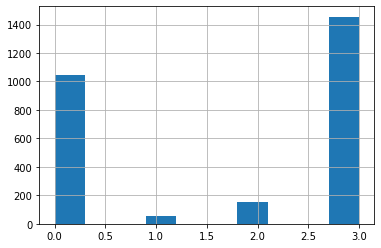

In [370]:
X.query("probabilityofmodel < 0.5").clientcategory.hist()

Seems score doesn't have such big correlation with probability indeed, so it's better we use a clientcategory as a common metric

In [30]:
y = dataset_cleaned.iloc[:, -3:]
y

,offercr_b,offerdo_b,offerpe_b
0,2,2,3
1,2,2,3
2,3,2,3
3,1,1,1
4,3,4,4
...,...,...,...
12511,1,1,1
12512,3,3,3
12513,3,3,3
12514,3,3,3


In [31]:
the_worst_samples = X.query("clientcategory in (0, 3) and probabilityofmodel <= 0.5")
y_worst = y.loc[the_worst_samples.index]

In [32]:
y_worst

,offercr_b,offerdo_b,offerpe_b
5,2,2,2
8,3,1,3
30,3,2,4
31,3,2,4
32,3,1,4
...,...,...,...
12503,2,1,2
12504,3,3,3
12505,1,1,1
12506,2,2,2


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Before we build any predictive model let's try to clusterize, probably it may show us additional info

### K Means

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)

In [36]:
pca = PCA(n_components=2)

pca.fit(X)

transformed = pca.transform(X)
transformed

array([[-2250.54116192,   229.39211992],
       [-4057.90708   ,   836.30499418],
       [-1984.46943944,  2491.33522587],
       ...,
       [-1326.43179311,   266.35731764],
       [-2379.68249014, -1245.27335711],
       [-2393.45242231, -4032.24013313]])

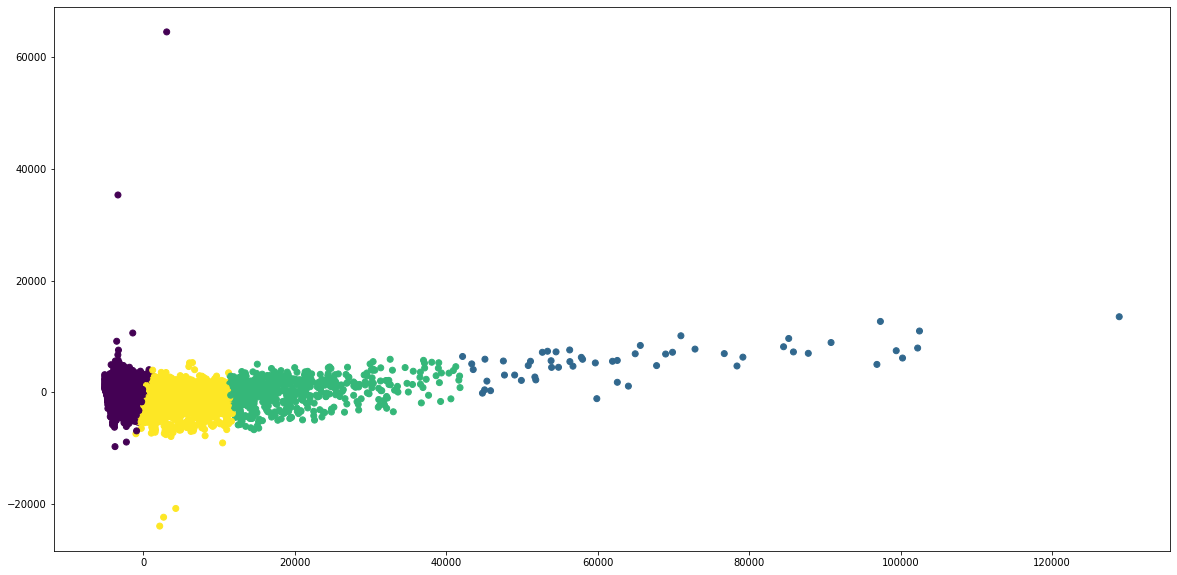

In [38]:
plt.figure(figsize=(20,10))
plt.scatter(x=transformed[:, 0], y=transformed[:, 1], c=kmeans.labels_)

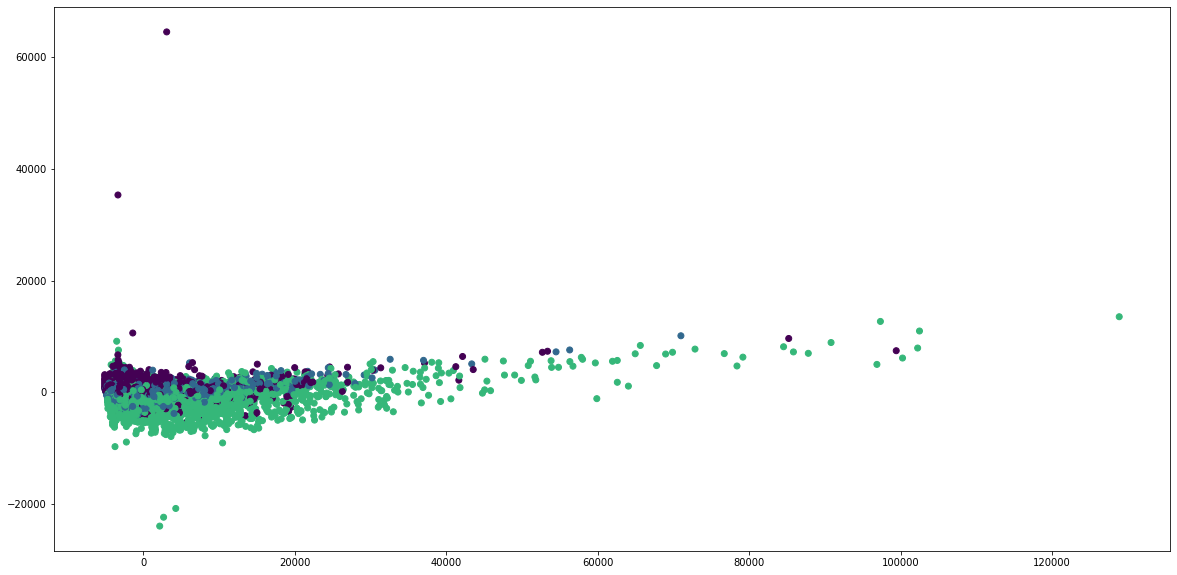

In [41]:
plt.figure(figsize=(20,10))

plt.scatter(x=transformed[:, 0], y=transformed[:, 1], c=dataset_cleaned.offercr_b)
plt.show()

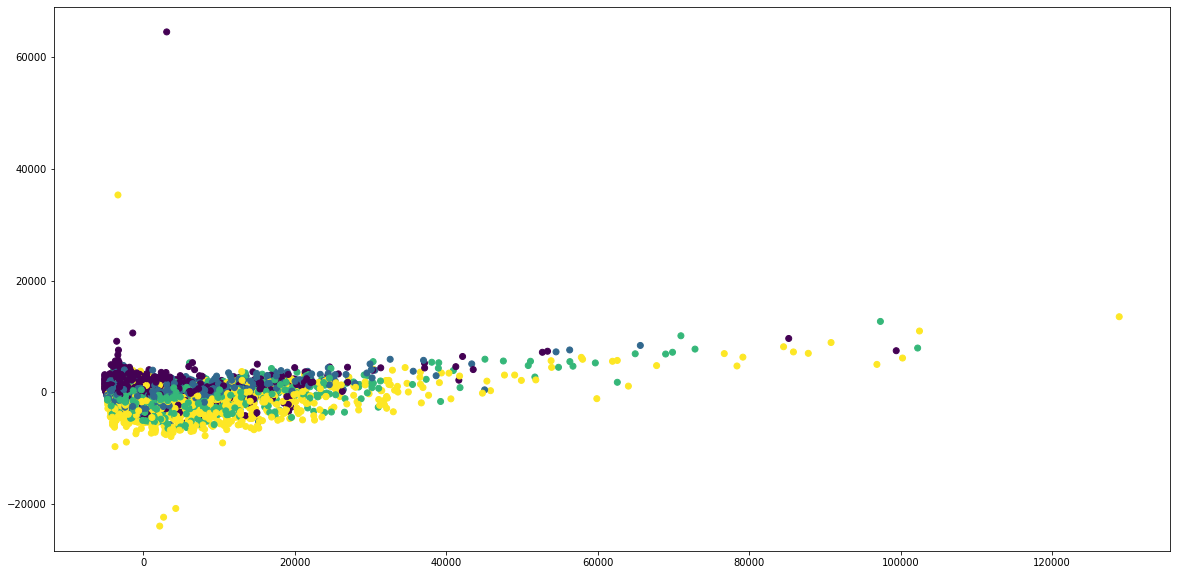

In [42]:
plt.figure(figsize=(20,10))

plt.scatter(x=transformed[:, 0], y=transformed[:, 1], c=dataset_cleaned.offerpe_b)

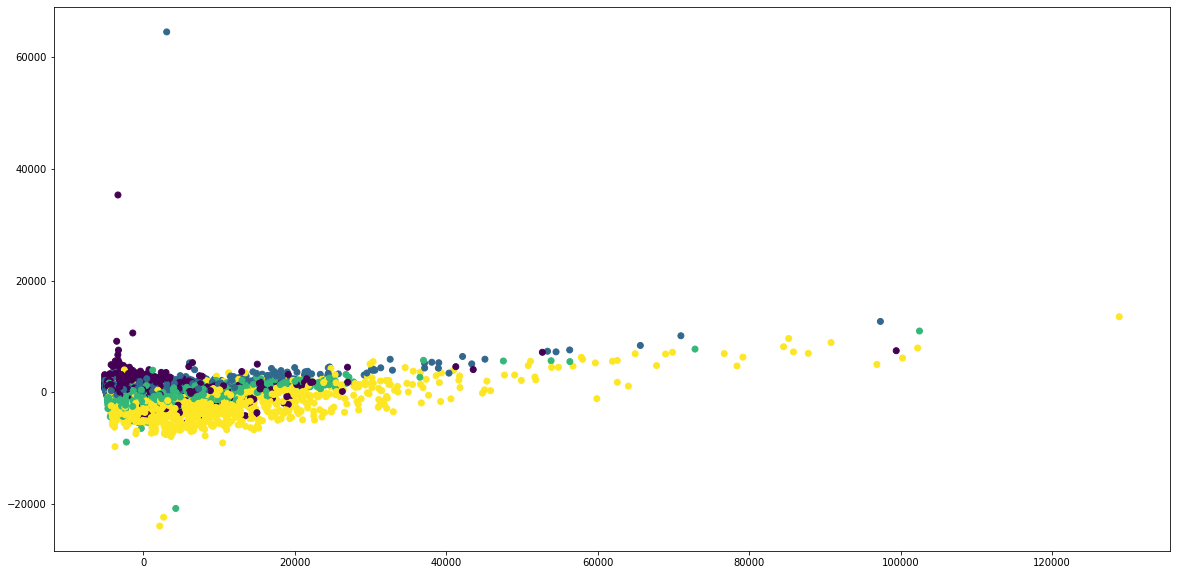

In [43]:
plt.figure(figsize=(20,10))

plt.scatter(x=transformed[:, 0], y=transformed[:, 1], c=dataset_cleaned.offerdo_b)

Doesn't seem it has any point

Let's suppose that all CreditOptionOffers are a vector representation of a client

E.g.

- client with all his features has [1, 1, 1] which means approximately declines everywhere which means no options suit
- client has got [1, 2, 3] which means his best shot is probably dolphin
etc.

### Simple Regressive NN. Output is the vector (3, ) itself 

In [463]:
y_train = np.asarray(y_train).astype(int)

model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.Dense(8, input_shape=(X.shape[1],)))
model.add(tensorflow.keras.layers.Activation('tanh'))
model.add(tensorflow.keras.layers.Dense(6))
model.add(tensorflow.keras.layers.Activation('tanh'))
model.add(tensorflow.keras.layers.Dense(4))
model.add(tensorflow.keras.layers.Activation('relu'))
model.add(tensorflow.keras.layers.Dense(3))
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

model.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=0.1)


Epoch 1/200
236/236 [==============================] - 2s 3ms/step - loss: 5.6216 - mae: 2.0801 - val_loss: 3.1372 - val_mae: 1.4187
Epoch 2/200
236/236 [==============================] - 0s 2ms/step - loss: 2.1433 - mae: 1.1682 - val_loss: 1.2010 - val_mae: 0.9215
Epoch 3/200
236/236 [==============================] - 1s 2ms/step - loss: 1.0767 - mae: 0.9051 - val_loss: 1.0540 - val_mae: 0.9009
Epoch 4/200
236/236 [==============================] - 0s 2ms/step - loss: 1.0398 - mae: 0.8967 - val_loss: 1.0430 - val_mae: 0.8968
Epoch 5/200
236/236 [==============================] - 0s 2ms/step - loss: 1.0250 - mae: 0.8900 - val_loss: 1.0388 - val_mae: 0.8922
Epoch 6/200
236/236 [==============================] - 0s 2ms/step - loss: 1.0021 - mae: 0.8776 - val_loss: 0.9888 - val_mae: 0.8674
Epoch 7/200
236/236 [==============================] - 0s 2ms/step - loss: 0.9533 - mae: 0.8478 - val_loss: 0.9200 - val_mae: 0.8175
Epoch 8/200
236/236 [==============================] - 0s 2ms/step - 

236/236 [==============================] - 0s 2ms/step - loss: 0.7648 - mae: 0.7137 - val_loss: 0.7875 - val_mae: 0.7207
Epoch 63/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7583 - mae: 0.7129 - val_loss: 0.7797 - val_mae: 0.7174
Epoch 64/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7534 - mae: 0.7112 - val_loss: 0.7845 - val_mae: 0.7293
Epoch 65/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7447 - mae: 0.7078 - val_loss: 0.7865 - val_mae: 0.7303
Epoch 66/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7429 - mae: 0.7081 - val_loss: 0.7733 - val_mae: 0.7185
Epoch 67/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7465 - mae: 0.7079 - val_loss: 0.7745 - val_mae: 0.7274
Epoch 68/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7458 - mae: 0.7087 - val_loss: 0.7813 - val_mae: 0.7137
Epoch 69/200
236/236 [==============================] - 0s 2ms/step - loss:

236/236 [==============================] - 0s 2ms/step - loss: 0.7089 - mae: 0.6843 - val_loss: 0.7204 - val_mae: 0.6950
Epoch 124/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7063 - mae: 0.6843 - val_loss: 0.7093 - val_mae: 0.6848
Epoch 125/200
236/236 [==============================] - 1s 2ms/step - loss: 0.7075 - mae: 0.6791 - val_loss: 0.7247 - val_mae: 0.6997
Epoch 126/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7079 - mae: 0.6818 - val_loss: 0.7605 - val_mae: 0.7076
Epoch 127/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7205 - mae: 0.6869 - val_loss: 0.7191 - val_mae: 0.6822
Epoch 128/200
236/236 [==============================] - 0s 2ms/step - loss: 0.6978 - mae: 0.6777 - val_loss: 0.7144 - val_mae: 0.6846
Epoch 129/200
236/236 [==============================] - 1s 2ms/step - loss: 0.7020 - mae: 0.6787 - val_loss: 0.7318 - val_mae: 0.6927
Epoch 130/200
236/236 [==============================] - 0s 2ms/step 

Epoch 184/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7155 - mae: 0.6847 - val_loss: 0.7255 - val_mae: 0.6958
Epoch 185/200
236/236 [==============================] - 1s 2ms/step - loss: 0.7028 - mae: 0.6796 - val_loss: 0.7365 - val_mae: 0.6983
Epoch 186/200
236/236 [==============================] - 0s 2ms/step - loss: 0.6974 - mae: 0.6755 - val_loss: 0.7252 - val_mae: 0.6933
Epoch 187/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7095 - mae: 0.6808 - val_loss: 0.7645 - val_mae: 0.7088
Epoch 188/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7264 - mae: 0.6860 - val_loss: 0.7480 - val_mae: 0.6977
Epoch 189/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7125 - mae: 0.6797 - val_loss: 0.7463 - val_mae: 0.7051
Epoch 190/200
236/236 [==============================] - 0s 2ms/step - loss: 0.7066 - mae: 0.6802 - val_loss: 0.7389 - val_mae: 0.6976
Epoch 191/200
236/236 [==============================] 

In [394]:
y_pred = np.floor(model.predict(X_test))
mean_absolute_percentage_error(y_test, y_pred)

0.3115132198283967

In [395]:
np.floor(y_pred)

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       ...,
       [1., 1., 1.],
       [1., 1., 1.],
       [2., 2., 2.]], dtype=float32)

In [396]:
y_test.values

array([[2, 2, 2],
       [2, 3, 2],
       [3, 4, 3],
       ...,
       [3, 2, 3],
       [1, 2, 1],
       [2, 2, 2]], dtype=object)

Let's try transform 3D vector to 1D and normalize it between 0 and 1

### Vector transformation

In [401]:
nmf = NMF(n_components=1)
min_max_scaler = p.MinMaxScaler()

nmf.fit(y)
min_max_scaler.fit(nmf.transform(y))

y_train_processed = min_max_scaler.transform(nmf.transform(y_train))
y_test_processed = min_max_scaler.transform(nmf.transform(y_test))

/home/toma_hal/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/toma_hal/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


### Simple Regressive NN. Output is a number between 0 and 1

In [464]:
model_bi = tensorflow.keras.Sequential()
model_bi.add(tensorflow.keras.layers.Dense(8, input_shape=(X.shape[1],)))
model_bi.add(tensorflow.keras.layers.Activation('tanh'))
model_bi.add(tensorflow.keras.layers.Dense(5))
model_bi.add(tensorflow.keras.layers.Activation('tanh'))

model_bi.add(tensorflow.keras.layers.Dense(4))
model_bi.add(tensorflow.keras.layers.Activation('tanh'))

model_bi.add(tensorflow.keras.layers.Dense(1))
model_bi.add(tensorflow.keras.layers.Activation('sigmoid'))

model_bi.compile(optimizer="Adam", loss="mse", metrics=["mae"])
model_bi.fit(X_train, y_train_processed, batch_size=32, epochs=200, validation_split=0.1)

Epoch 1/200
236/236 [==============================] - 1s 3ms/step - loss: 0.1051 - mae: 0.2797 - val_loss: 0.1004 - val_mae: 0.2683
Epoch 2/200
236/236 [==============================] - 1s 2ms/step - loss: 0.0916 - mae: 0.2571 - val_loss: 0.0928 - val_mae: 0.2564
Epoch 3/200
236/236 [==============================] - 1s 3ms/step - loss: 0.0846 - mae: 0.2410 - val_loss: 0.0870 - val_mae: 0.2413
Epoch 4/200
236/236 [==============================] - 1s 2ms/step - loss: 0.0824 - mae: 0.2357 - val_loss: 0.0870 - val_mae: 0.2387
Epoch 5/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0820 - mae: 0.2321 - val_loss: 0.0846 - val_mae: 0.2369
Epoch 6/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0812 - mae: 0.2315 - val_loss: 0.0841 - val_mae: 0.2355
Epoch 7/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0811 - mae: 0.2301 - val_loss: 0.0833 - val_mae: 0.2350
Epoch 8/200
236/236 [==============================] - 0s 2ms/step - 

236/236 [==============================] - 1s 2ms/step - loss: 0.0678 - mae: 0.2043 - val_loss: 0.0734 - val_mae: 0.2146
Epoch 63/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0656 - mae: 0.2016 - val_loss: 0.0713 - val_mae: 0.2096
Epoch 64/200
236/236 [==============================] - 1s 2ms/step - loss: 0.0645 - mae: 0.1994 - val_loss: 0.0697 - val_mae: 0.2085
Epoch 65/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0645 - mae: 0.2001 - val_loss: 0.0736 - val_mae: 0.2124
Epoch 66/200
236/236 [==============================] - 1s 2ms/step - loss: 0.0657 - mae: 0.1990 - val_loss: 0.0712 - val_mae: 0.2083
Epoch 67/200
236/236 [==============================] - 1s 2ms/step - loss: 0.0660 - mae: 0.1990 - val_loss: 0.0720 - val_mae: 0.2093
Epoch 68/200
236/236 [==============================] - 1s 2ms/step - loss: 0.0666 - mae: 0.2018 - val_loss: 0.0739 - val_mae: 0.2166
Epoch 69/200
236/236 [==============================] - 0s 2ms/step - loss:

236/236 [==============================] - 0s 2ms/step - loss: 0.0680 - mae: 0.2033 - val_loss: 0.0711 - val_mae: 0.2113
Epoch 124/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.2002 - val_loss: 0.0685 - val_mae: 0.2034
Epoch 125/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0650 - mae: 0.1972 - val_loss: 0.0736 - val_mae: 0.2122
Epoch 126/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.2029 - val_loss: 0.0708 - val_mae: 0.2078
Epoch 127/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0647 - mae: 0.1973 - val_loss: 0.0699 - val_mae: 0.2052
Epoch 128/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0669 - mae: 0.1995 - val_loss: 0.0768 - val_mae: 0.2207
Epoch 129/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0690 - mae: 0.2085 - val_loss: 0.0737 - val_mae: 0.2134
Epoch 130/200
236/236 [==============================] - 0s 2ms/step 

Epoch 184/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0661 - mae: 0.2011 - val_loss: 0.0712 - val_mae: 0.2090
Epoch 185/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0657 - mae: 0.2001 - val_loss: 0.0688 - val_mae: 0.2061
Epoch 186/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0661 - mae: 0.2022 - val_loss: 0.0745 - val_mae: 0.2134
Epoch 187/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.2029 - val_loss: 0.0702 - val_mae: 0.2073
Epoch 188/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.2017 - val_loss: 0.0735 - val_mae: 0.2140
Epoch 189/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0677 - mae: 0.2049 - val_loss: 0.0748 - val_mae: 0.2169
Epoch 190/200
236/236 [==============================] - 0s 2ms/step - loss: 0.0671 - mae: 0.2039 - val_loss: 0.0759 - val_mae: 0.2187
Epoch 191/200
236/236 [==============================] 

In [406]:
y_pred = model_bi.predict(X_test).reshape(-1, 1)
y_pred_processed = np.floor(nmf.inverse_transform(min_max_scaler.inverse_transform(y_pred)))

mean_absolute_percentage_error(y_test, y_pred_processed)

130/130 [==============================] - 0s 1ms/step


0.34003738669678985

In [407]:
y_pred_processed

array([[1., 1., 1.],
       [1., 2., 2.],
       [1., 1., 1.],
       ...,
       [1., 2., 2.],
       [1., 1., 1.],
       [2., 2., 2.]])

In [409]:
y_test.values

array([[2, 2, 2],
       [2, 3, 2],
       [3, 4, 3],
       ...,
       [3, 2, 3],
       [1, 2, 1],
       [2, 2, 2]], dtype=object)

### Simple Lasso Regressor with L1 regularization

In [410]:
regressor = Lasso()

regressor.fit(X_train, y_train_processed)

Lasso()

In [411]:
y_pred = regressor.predict(X_test).reshape(-1, 1)
y_pred_processed = np.floor(nmf.inverse_transform(min_max_scaler.inverse_transform(y_pred)))

mean_absolute_percentage_error(y_test, y_pred_processed)

0.3382420183436868

In [412]:
y_pred_processed

array([[1., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.],
       ...,
       [1., 2., 2.],
       [1., 2., 2.],
       [2., 2., 2.]])

In [414]:
y_test.values

array([[2, 2, 2],
       [2, 3, 2],
       [3, 4, 3],
       ...,
       [3, 2, 3],
       [1, 2, 1],
       [2, 2, 2]], dtype=object)

Lasso seems to show closer to the truth results.

Now let's train a model that would estimate risk tendency from credit options vector
and see how good are models in this case

In [425]:
the_worst_samples.index

united_again = pd.concat([X, y], axis=1)
united_again['risky'] = np.ones(shape=(len(united_again), 1))
united_again['risky'].loc[the_worst_samples.index] = 0

/tmp/ipykernel_89204/2088291906.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  united_again['risky'].loc[the_worst_samples.index] = 0


In [428]:
X_r = united_again.iloc[:, :-1]
y_r = united_again.iloc[:, -1]

X_train_r, X_test_r, y_train_r, y_test_r= train_test_split(
    X_r, y_r, test_size=0.33, random_state=42)

In [435]:
y_pred_ = regressor.predict(X_test_r.iloc[:, :-3]).reshape(-1, 1)
y_pred_processed_ = np.floor(nmf.inverse_transform(min_max_scaler.inverse_transform(y_pred_)))

In [436]:
clf = LogisticRegression()
clf.fit(X_train_r, y_train_r)
y_predicted_r = clf.predict(X_test_r)

/home/toma_hal/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [437]:
f1_score(y_test_r, y_predicted_r)

0.93

In [438]:
y_predicted_r = clf.predict(np.concatenate([X_test_r.iloc[:, :-3], y_pred_processed_], axis=1))

f1_score(y_test_r, y_predicted_r)

/home/toma_hal/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.9334663057415586

In [453]:
y_test_r.values[np.where(y_predicted_r == 0)[0]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Now let's try to train only on credit options vector

In [454]:
X_train_r, X_test_r, y_train_r, y_test_r= train_test_split(
    y, y_r, test_size=0.33, random_state=42)

clf = LogisticRegression()
clf.fit(X_train_r, y_train_r)
y_predicted_r = clf.predict(X_test_r)

In [455]:
f1_score(y_test_r, y_predicted_r)

0.886522911051213

In [460]:
y_pred_ = regressor.predict(X).reshape(-1, 1)
y_pred_processed_ = np.floor(nmf.inverse_transform(min_max_scaler.inverse_transform(y_pred_)))

In [462]:
y_predicted_r = clf.predict(y_pred_processed_)

f1_score(y_r, y_predicted_r)

/home/toma_hal/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.8890269886363636

Seems that credit option vector does have certain pattern thus we can predict by if it worths it.

Let's see the NNs results 

In [465]:
# model with normalized from 0 to 1 output

y_pred_ = model_bi.predict(X)
y_pred_processed_ = np.floor(nmf.inverse_transform(min_max_scaler.inverse_transform(y_pred_)))

y_predicted_r = clf.predict(y_pred_processed_)

f1_score(y_r, y_predicted_r)

392/392 [==============================] - 1s 1ms/step


/home/toma_hal/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.8891452915594212

In [466]:
# model with initial credit option vector

y_pred_ = model.predict(X)
y_pred_processed_ = np.floor(y_pred_)

y_predicted_r = clf.predict(y_pred_processed_)

f1_score(y_r, y_predicted_r)

392/392 [==============================] - 1s 1ms/step


/home/toma_hal/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.8890466891532044

What could be on the roadmap next?

- investigate wider range of correlations
- models testing (try more models for classifier and adjust regression)
- models parameters finetuning 
- uniting the best version into a Pipeline Object to get a reproducible result